In [1]:
# install pygame
# pip install pygame

# install ple
# git clone https://github.com/ntasfi/PyGame-Learning-Environment.git
# cd PyGame-Learning-Environment/
# pip install -e .

# install gym_ple
# pip install gym_ple



In [29]:
%matplotlib inline
from Utils import Environment, Memory
import os
 
import matplotlib
from matplotlib.pyplot import imshow, show
from collections import deque
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import warnings
warnings.filterwarnings('ignore')
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.__version__

'0.4.1'

In [2]:
env = Environment()
env.action_space, env.observation_space

WARN: Environment '<class 'gym_ple.ple_env.PLEEnv'>' has deprecated methods '_step' and '_reset' rather than 'step' and 'reset'. Compatibility code invoked. Set _gym_disable_underscore_compat = True to disable this behavior.


(2, Box(512, 288, 3))

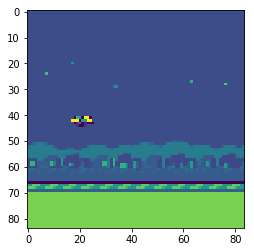

In [12]:
env.init()
env.step(1)
imshow(env.get_screen())

In [3]:
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(4, 32, kernel_size=8, stride=4),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.fc1 = nn.Sequential(
            nn.Linear(3136, 512),
            nn.ReLU()
        )
        self.fc2 = nn.Linear(512, 2)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x.view(x.size(0), -1))
        return self.fc2(x)

In [25]:
class Agent(object):
    def __init__(self):
        self.env = Environment()
        self.dqn = DQN().to(device)
        self.target = DQN().to(device)
        self.target.load_state_dict(self.dqn.state_dict())
        self.target.eval()
        self.target_update_interval = 1000
#         self.optimizer = optim.RMSprop(self.dqn.parameters())
        self.optimizer = optim.Adam(self.dqn.parameters(), lr=0.0001)
        
        #play params
        self.play_interval = 1000
        self.play_repeat = 1
        self.best_steps_done = 0
        self.best_score = -1000
        
        self.seed = 111
        self.gamma = 0.99
        self.epsilon_start = 1.0
        self.epsilon_decay = 100000
        self.epsilon_stop = 0.01
        self.batch_size = 32
#         self.max_step = 1000
        self.global_steps = 0
        
        self.memory = Memory(50000, batch_size=self.batch_size)

        self.frame_skipping = 4
        self.state_buffer_size = 4
        self.state_buffer = deque(maxlen=self.state_buffer_size)
        
    def save_checkpoint(self, filename='checkpoints/checkpoint.pth'):
        dirpath = os.path.dirname(filename)

        if not os.path.exists(dirpath):
            os.mkdir(dirpath)

        checkpoint = {
            'dqn': self.dqn.state_dict(),
            'target': self.target.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'global_steps': self.global_steps,
            'best_score': self.best_score,
            'best_steps_done': self.best_steps_done
        }
        torch.save(checkpoint, filename)
        
    def load_checkpoint(self, filename='checkpoints/checkpoint.pth'):
        checkpoint = torch.load(filename, map_location=device.type)
        self.dqn.load_state_dict(checkpoint['dqn'])
        self.target.load_state_dict(checkpoint['target'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.global_steps = checkpoint['global_steps']
        self.best_score = checkpoint['best_score']
        self.best_steps_done = checkpoint['best_steps_done']
        
        
    def play(self, human=True):
        self.env.reset()
        state = self.get_initial_state()
        steps_done = 0
        total_score = 0
        
        while True:

            state = torch.FloatTensor([state]).to(device)
            
            self.dqn.eval()
            action = self.dqn(state).cpu().max(1)[1]

            for _ in range(self.frame_skipping):
                if human:
                    screen = self.env.game.render(mode='human')
                _, reward, done, _ = self.env.step(action)

                next_state = self.env.get_screen()
                self.state_buffer.append(next_state)
                state = np.array(self.state_buffer)

                total_score += reward

                if done:
                    break

            steps_done += 1
            
            if done:
                self.dqn.train()
                break
        self.env.game.close()
        return total_score, steps_done

    def get_initial_state(self):
        self.env.reset()
        state = self.env.get_screen()
        
        self.state_buffer = deque(maxlen=self.state_buffer_size)
        [self.state_buffer.append(state) for _ in range(self.state_buffer_size)]
        return np.array(self.state_buffer)
    
    def optimize(self):
        transitions = self.memory.sample()

        states = torch.cat(transitions.state).to(device)
        actions = torch.cat(transitions.action).to(device)
        rewards = torch.cat(transitions.reward).to(device)
        
        non_final_mask = torch.tensor(list(map(lambda s: s is not None, transitions.next_state)), 
                                      device=device, dtype=torch.uint8)
        non_final_next_states = torch.cat([s for s in transitions.next_state
                                            if s is not None])
        
        states = states.view([self.batch_size, self.state_buffer_size, self.env.width, self.env.height])
        q_values = self.dqn(states).gather(1, actions)
        
        target_values = torch.zeros(self.batch_size, device=device)
        non_final_next_states = non_final_next_states.view([-1, self.state_buffer_size, self.env.width, self.env.height]).to(device)
        target_values[non_final_mask] = self.target(non_final_next_states).max(1)[0].detach()
        
        rewards.data.clamp_(-1, 1)
        
        expected_state_action_values = (target_values * self.gamma) + rewards
        
        loss = F.smooth_l1_loss(q_values, expected_state_action_values.unsqueeze(1))
        
        self.optimizer.zero_grad()
        loss.backward()
        for param in self.dqn.parameters():
            param.grad.data.clamp_(-1, 1)
        self.optimizer.step()
        
        
        reward_score = int(torch.sum(rewards).cpu().detach().numpy())
        
        return loss.cpu().detach().numpy(), reward_score


    def action(self, state):
        eps = self.epsilon_stop + (self.epsilon_start - self.epsilon_stop) * np.exp(-self.global_steps/self.epsilon_decay)
        if np.random.uniform() <= eps:
            state = torch.FloatTensor([state]).to(device)
            with torch.no_grad():
                return self.dqn(state).max(1)[1].view(-1,1).cpu(), eps
        else:
            sample_action = self.env.game.action_space.sample()
            action = torch.LongTensor([[sample_action]])
            return action, eps
        
    def train(self):
        
        while True:
            self.env.reset()
            state = self.get_initial_state()
            
            losses = []
            rewards = []
            steps_done = 0
            eps = self.epsilon_start
            
            done = False
            while not done:
                action, e = self.action(state)
                eps = e
                
                for _ in range(self.frame_skipping):
                    _, reward, done, _ = self.env.step(action.item())
                    next_state = self.env.get_screen()
                    self.state_buffer.append(next_state)
                    
                    if done:
                        break
            
            
                next_state = np.array(self.state_buffer)
                
                if done:
                    self.memory.add(state, action, reward, None)
                else:
                    self.memory.add(state, action, reward, next_state)

                state = next_state
                
                if self.memory.is_ready():
                    l, r = self.optimize()
                    losses.append(l)
                    rewards.append(r)

                steps_done += 1
                self.global_steps += 1
                
                # update target network
                if self.global_steps % self.target_update_interval == 0:
                    print('update target network!')
                    self.target.load_state_dict(self.dqn.state_dict())
              
                # Play
                if self.global_steps % self.play_interval == 0:
                    scores = []
                    total_steps_done = []
                    for _ in range(self.play_repeat):
                        score, steps_done = self.play(human=True)
                        scores.append(score)
                        total_steps_done.append(steps_done)
                        
                    real_score = int(np.mean(scores))
                    real_steps_done = int(np.mean(total_steps_done))

                    if self.best_steps_done <= real_steps_done:
                        self.best_score = real_score
                        self.best_steps_done = real_steps_done

                        self.save_checkpoint(
                            filename=f'dqn_checkpoints/chkpoint_{self.best_steps_done}_{self.best_score}.pth')

            if not np.isnan(np.mean(losses)):
                print('global_steps:%d, episode_steps:%d, loss:%.6f, rewards:%d, eps:%.6f'%(self.global_steps, steps_done, np.mean(losses), np.mean(rewards), eps))
                    

In [26]:
# training
# agent = Agent() 
# agent.train()

In [10]:
# agent.save_checkpoint('dqn_checkpoints/exp_01.pth')

In [37]:
# play
agent = Agent()
agent.load_checkpoint('dqn_checkpoints/chkpoint_771_76.pth')
agent.play(human=True)


(15.0, 197)

In [ ]:
# references
# https://github.com/AndersonJo/dqn-pytorch/blob/master/dqn.py